In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

In [3]:
X_centered  = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [42]:
Vt

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ],
       [-0.08626012, -0.31420255,  0.94542898]])

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [8]:
X2D_using_svd = X2D

In [9]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

## PCA using Scikit-Learn

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [11]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [12]:
np.allclose(X2D, X2D_using_svd)

False

In [13]:
X3D_inv = pca.inverse_transform(X2D)

In [14]:
np.allclose(X3D_inv, X)

False

## PCA

In [15]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [16]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [17]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [18]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

## MNIST

In [2]:
import pandas as pd
data = pd.read_csv('mnist_784.csv')

In [3]:
y = data['class']
X = data.drop(['class'], axis = 1)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [9]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [10]:
d

154

In [11]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [12]:
pca.n_components_

154

In [13]:
np.sum(pca.explained_variance_ratio_)

0.9504042024953484

In [14]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [15]:
X_reduced_pca = X_reduced

## Incremental PCA

In [32]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100

inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

In [ ]:
X_reduced_inc_pca = X_reduced

In [ ]:
np.allclose(pca.mean_, inc_pca.mean_)

In [ ]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

## Kernel PCA

In [33]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=0)
y = t > 6.9

In [34]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03888888888888889, 'kpca__kernel': 'rbf'}


In [37]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0389,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [38]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

29.29709340907459

## LLE

In [39]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=0)

In [40]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=0)
X_reduced = lle.fit_transform(X)

<IPython.core.display.Javascript object>


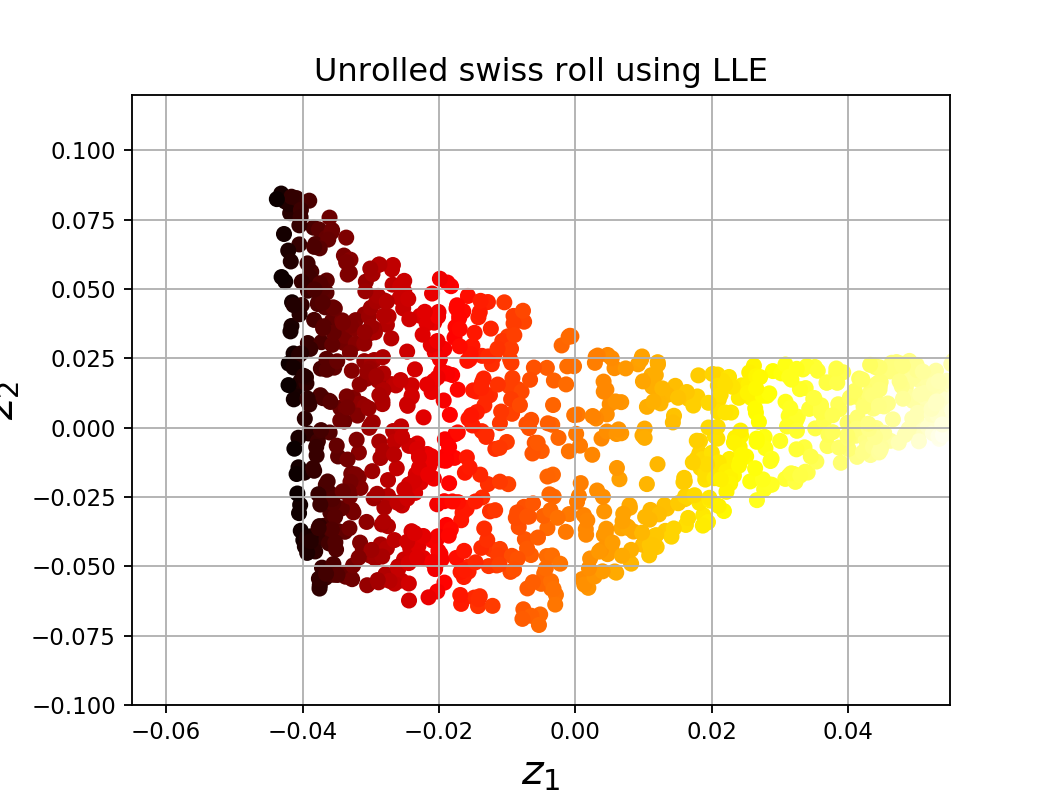

In [41]:
%matplotlib notebook 

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)